<a href="https://colab.research.google.com/github/hopedom/DS5/blob/main/day7_%EB%89%B4%EC%8A%A4_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98_%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 개요

프로젝트: Vocabulary Size를 변경해서 시도해보기
___

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.

```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```

앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 `<unk>`로 처리하는 원리였었죠.

아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요.

라이브러리 버전을 확인해 봅니다
___
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow
import matplotlib
import seaborn
import numpy
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.19.0
3.10.0
0.13.2
2.0.2
2.2.2
1.6.1


1. 모든 단어 사용
___
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
```
2. 빈도수 상위 5,000개의 단어만 사용
___
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
```
3. 직접 단어 개수를 설정해서 사용
___
위 단계에서 5000으로 제시된 `num_words`를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요. 최소 3가지 경우 이상을 실험해 보기를 권합니다.

>사용할 모델
>
>나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅


4. 딥러닝 모델과 비교해 보기
___
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정 분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

# BoW + ML Model

분석 계획
___
1. num_words에 따른 reuters 데이터 불러오기 전처리 함수 생성
    - reuters 데이터 및 word_index 로드
    - index_to_word 변환
    - retuers 데이터를 텍스트 데이터로 복원
    - BoW 로 변환

2. num_words와 BoW를 고려한 모델 학습
    - 모델: ComplementNB, LogisticRegression, SVM, RandomForest, XGBoost, VotingClf
    - BoW : DTM, TF-IDF

3. 결과 정리 및 비교


## 데이터 전처리 함수

In [26]:
from keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

def preprocess_bow(num_words=None, bow_type='DTM'):
    """
    지정된 num_words에 맞게 Reuters 데이터를 로드하고 X_train, X_test는 BoW로 변환합니다.

    Args:
        num_words (int or None): 사용할 상위 빈도 단어 개수. None이면 모든 단어 사용.
        bow_type (str): 'DTM' 또는 'TF-IDF' 중 선택.

    Returns:
        X_train_vec, X_test_vec, y_train, y_test
    """

    # 1. 데이터 로드
    (X_train_index, y_train), (X_test_index, y_test) = reuters.load_data(num_words=num_words)

    # 2. word_index 로드 및 index_to_word 변환
    word_index = reuters.get_word_index()
    index_to_word = {v + 3: k for k, v in word_index.items()}
    index_to_word[0] = '<pad>'
    index_to_word[1] = '<start>'
    index_to_word[2] = '<unk>'

    # 3. 텍스트 데이터로 복원
    def indices_to_text(indices):
        return ' '.join([index_to_word.get(i, '<unk>') for i in indices])

    X_train_text = [indices_to_text(indices) for indices in X_train_index]
    X_test_text = [indices_to_text(indices) for indices in X_test_index]

    # 4. BoW 변환
    dtmvector = CountVectorizer()
    X_train_dtm = dtmvector.fit_transform(X_train_text)
    X_test_dtm = dtmvector.transform(X_test_text)

    if bow_type == 'DTM':
        X_train_vec = X_train_dtm
        X_test_vec = X_test_dtm

    elif bow_type == 'TF-IDF':
        tfidf_transformer = TfidfTransformer()
        X_train_vec = tfidf_transformer.fit_transform(X_train_dtm)
        X_test_vec = tfidf_transformer.transform(X_test_dtm)
    else:
        raise ValueError("bow_type은 'DTM' 또는 'TF-IDF'여야 합니다.")

    return X_train_vec, X_test_vec, y_train, y_test

## 모델 학습

In [27]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    print(f"난수 시드가 {seed}로 고정되었습니다.")

set_seed(42)

난수 시드가 42로 고정되었습니다.


In [28]:
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import xgboost as xgb
#import lightgbm as lgb # 학습이 원활히 안되서 제외

# 모델 정의
models = {
    'CNB': ComplementNB(),
    'LR': LogisticRegression(max_iter = 3000, random_state = 42),
    #'SVM': SVC(max_iter = 3000, kernel = 'linear', probability = True, random_state = 42) # SVM을 soft방식의 votingclf에 추가시키고자 넣었는데 세션이 자꾸 죽어서 제외시켰습니다.
    'SVM': LinearSVC(max_iter=3000, dual=False, random_state=42),
    'RF': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(
        objective='multi:softmax', num_class=46, # 다중분류 학습을 위한 param
        random_state=42, n_jobs=-1
    )
}

soft_voting =  VotingClassifier(
    estimators=[
        ('CNB', models['CNB']), ('LR', models['LR']), ('RF', models['RF']), ('XGB', models['XGB'])
        ], voting='soft', n_jobs= -1) # LinearSVC는 'hard'방식만 가능하여 제외 # SVC는 계산량이 너무 많아서 제외

models['Voting'] = soft_voting

In [32]:
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import pandas as pd

# 모델 학습
n_words_list = [5000, 10000, 20000, None]
bow_types = ['DTM', 'TF-IDF']
results = []

for n_words in n_words_list:
    for bow_type in bow_types:
        print(f"\n--- 실험 시작: num_words = {n_words}, BoW:{bow_type} ---")

        # 1. 전처리 및 데이터 분할
        X_train, X_test, y_train, y_test = preprocess_bow(num_words=n_words, bow_type=bow_type)

        # 2. 모델 학습 및 평가
        for model_name, model in models.items():
            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()
            elapsed_time = end_time - start_time

            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_weighted = f1_score(y_test, y_pred, average='weighted')

            # 결과 저장
            results.append({
                'num_words': n_words,
                'bow_type': bow_type,
                'model': model_name,
                'accuracy': acc,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            })

            print(f"  {model_name} 정확도: {acc:.4f} F1(macro): {f1_macro:.4f} F1(weighted): {f1_weighted:.4f} (학습 시간: {elapsed_time:.2f}초)")


--- 실험 시작: num_words = 5000, BoW:DTM ---
  CNB 정확도: 0.7685 F1(macro): 0.4442 F1(weighted): 0.7424 (학습 시간: 0.03초)
  LR 정확도: 0.7907 F1(macro): 0.5910 F1(weighted): 0.7819 (학습 시간: 50.60초)
  SVM 정확도: 0.7814 F1(macro): 0.6092 F1(weighted): 0.7754 (학습 시간: 51.85초)
  RF 정확도: 0.7618 F1(macro): 0.4370 F1(weighted): 0.7390 (학습 시간: 4.50초)
  XGB 정확도: 0.7947 F1(macro): 0.6415 F1(weighted): 0.7875 (학습 시간: 11.53초)
  Voting 정확도: 0.8121 F1(macro): 0.6352 F1(weighted): 0.8028 (학습 시간: 53.53초)

--- 실험 시작: num_words = 5000, BoW:TF-IDF ---
  CNB 정확도: 0.7707 F1(macro): 0.4820 F1(weighted): 0.7459 (학습 시간: 0.03초)
  LR 정확도: 0.7979 F1(macro): 0.4814 F1(weighted): 0.7762 (학습 시간: 4.38초)
  SVM 정확도: 0.8290 F1(macro): 0.6813 F1(weighted): 0.8230 (학습 시간: 2.00초)
  RF 정확도: 0.7622 F1(macro): 0.4363 F1(weighted): 0.7388 (학습 시간: 4.77초)
  XGB 정확도: 0.7983 F1(macro): 0.6396 F1(weighted): 0.7916 (학습 시간: 176.63초)
  Voting 정확도: 0.8112 F1(macro): 0.6329 F1(weighted): 0.8027 (학습 시간: 224.60초)

--- 실험 시작: num_words = 10000, BoW:DTM 

## 결과 분석

In [33]:
# 결과 정리
results_df = pd.DataFrame(results)
print("\n--- 전체 실험 결과 요약  ---")
results_df.sort_values(by=['accuracy', 'f1_weighted'], ascending=False)


--- 전체 실험 결과 요약  ---


,num_words,bow_type,model,accuracy,f1_macro,f1_weighted
20,10000.0,TF-IDF,SVM,0.829920,0.680843,0.823688
44,NaN,TF-IDF,SVM,0.829475,0.688698,0.823668
32,20000.0,TF-IDF,SVM,0.829029,0.689207,0.823254
8,5000.0,TF-IDF,SVM,0.829029,0.681329,0.823033
29,20000.0,DTM,Voting,0.817008,0.631479,0.808427
41,NaN,DTM,Voting,0.816118,0.620137,0.806966
17,10000.0,DTM,Voting,0.813891,0.626405,0.804549
47,NaN,TF-IDF,Voting,0.812110,0.651251,0.804038
5,5000.0,DTM,Voting,0.812110,0.635151,0.802812
11,5000.0,TF-IDF,Voting,0.811220,0.632900,0.802689


In [51]:
results_df.loc[results_df.groupby(['model'])['accuracy'].idxmax()].sort_values('accuracy', ascending=False)

,num_words,bow_type,model,accuracy,f1_macro,f1_weighted
20,10000.0,TF-IDF,SVM,0.829920,0.680843,0.823688
29,20000.0,DTM,Voting,0.817008,0.631479,0.808427
46,NaN,TF-IDF,XGB,0.800089,0.662689,0.794776
7,5000.0,TF-IDF,LR,0.797863,0.481380,0.776227
24,20000.0,DTM,CNB,0.777827,0.497378,0.757312
9,5000.0,TF-IDF,RF,0.762244,0.436319,0.738766


### Accuracy 기준

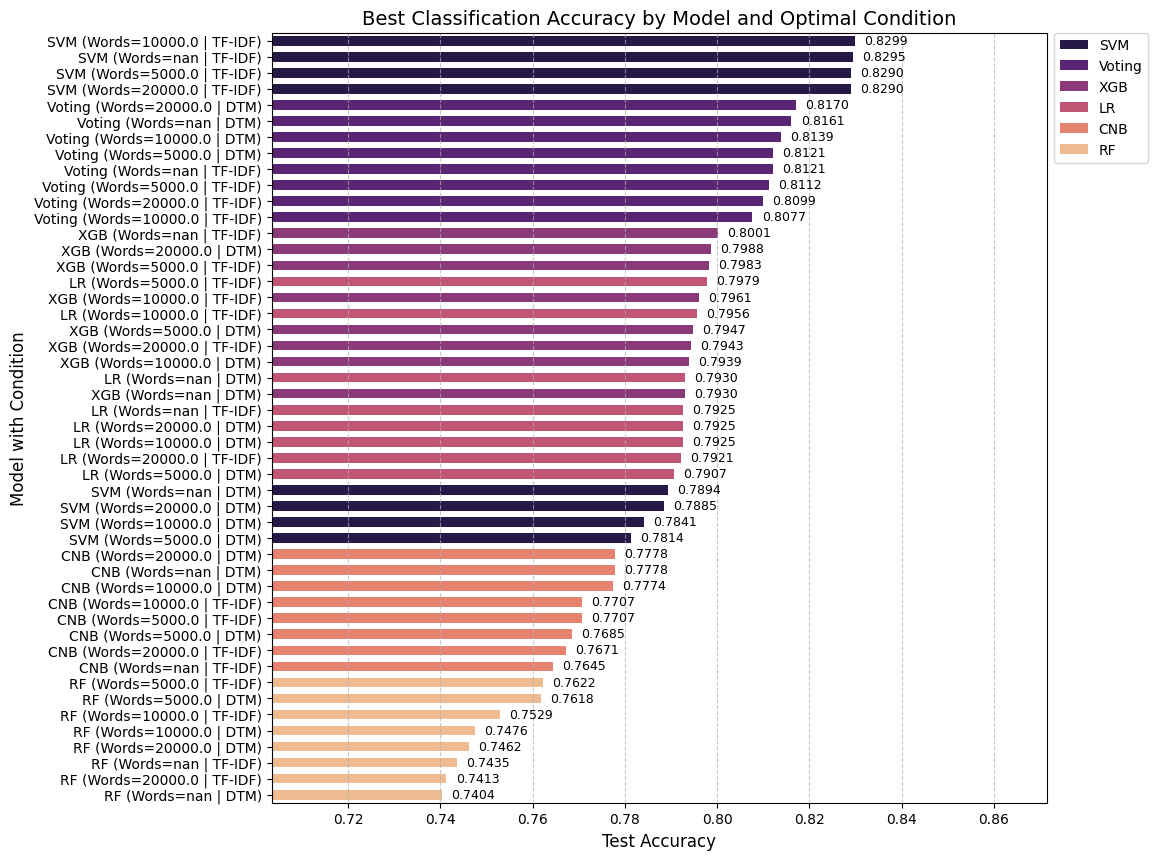

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

best_per_model = pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)

# 1. Y축 레이블(모델 이름 + 조건) 생성
# 'Model (Words=Num | Type)' 형식으로 결합
best_per_model['Full_Label'] = best_per_model['model'] + ' (Words=' + best_per_model['num_words'].astype(str) + ' | ' + best_per_model['bow_type'].astype(str) + ')'

# 2. 그래프 생성 (Barh)
plt.figure(figsize=(10, 10))
# x축에 accuracy, y축에 결합된 레이블 사용
barhplot = sns.barplot(
    x='accuracy',
    y='Full_Label',
    data=best_per_model,
    hue = 'model',
    width=0.6,
    palette='magma' # 새로운 색상 팔레트
)

plt.title('Best Classification Accuracy by Model and Optimal Condition', fontsize=14)
plt.xlabel('Test Accuracy', fontsize=12)
plt.ylabel('Model with Condition', fontsize=12)
plt.xlim(best_per_model['accuracy'].min() * 0.95, best_per_model['accuracy'].max() * 1.05) # X축 범위 조정

# 막대 끝에 정확도 값 표시
for index, row in best_per_model.iterrows():
    barhplot.text(
        row['accuracy'] + 0.002, # 막대 끝에서 오른쪽으로 약간 이동
        index,
        f"{row['accuracy']:.4f}",
        color='black',
        ha="left",
        va="center",
        size=9
    )

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.) # 범례 위치 조정
plt.show()

- `SVM + TF-IDF`가 모든 num_words 조합에서 가장 높은 정확도를 보여주었습니다. 하지만 `SVM+DTM`은 성능이 많이 뒤쳐지는 것으로 나타났습니다.
- 그 다음으로는 Voting 분류기가 모든 조합에서 준수한 정확도를 보여주었습니다.
- `RandomForest`는 모든 num_words, bow_type 조합에서 가장 낮은 정확도를 보여주었습니다.
이 결과는 imbalanced multi class 분포를 가진 텍스트 다중 분류 문제에서 sparse matrix 형태로 출력하는 BoW를 활용한 분류에 취약함을 보여주었다고 생각합니다.

### F1-Score 기준

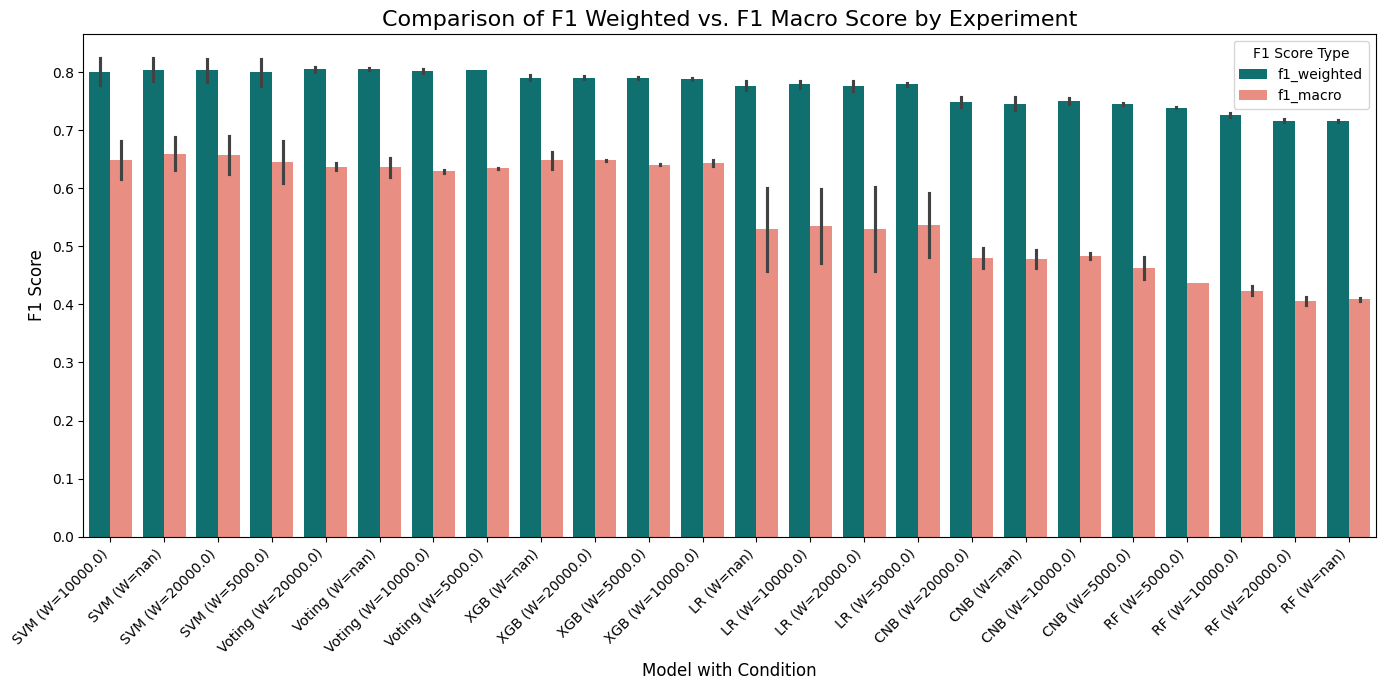

In [95]:
# `F1_macro`와 `F1_weighted`를 비교한 그래프
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. 시각화를 위해 F1 Score 열을 하나로 합쳐서 재구조화 (Wide to Long)
f1_melted = results_df.melt(
    id_vars=['model', 'num_words', 'bow_type'],
    value_vars=['f1_macro', 'f1_weighted'],
    var_name='F1_Type',
    value_name='F1_Score'
).sort_values('F1_Score', ascending=False)

# 2. X축 레이블을 결합하여 생성
f1_melted['Condition'] = f1_melted['model'] + ' (W=' + f1_melted['num_words'].astype(str) + ')'

plt.figure(figsize=(14, 7))

# Bar Plot 생성
barplot = sns.barplot(
    x='Condition',
    y='F1_Score',
    hue='F1_Type', # f1_macro와 f1_weighted를 그룹으로 구분
    data=f1_melted,
    palette={'f1_weighted': 'teal', 'f1_macro': 'salmon'} # 색상 지정
)

plt.title('Comparison of F1 Weighted vs. F1 Macro Score by Experiment', fontsize=16)
plt.xlabel('Model with Condition', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45, ha='right') # X축 레이블 회전하여 가독성 확보

# 막대 위에 값 표시 (선택 사항: 복잡해 보일 수 있으므로 주의)
# for container in barplot.containers:
#     barplot.bar_label(container, fmt='%.3f', size=8)

plt.legend(title='F1 Score Type')
plt.tight_layout()
plt.show()

`class_weight`를 고려하지 않은 학습임에도 불구하고 `SVM`, `Voting` 그리고 `XGB`는 minor class를 비교적 잘 예측한 것으로 확인되었습니다.

### num_words 기준

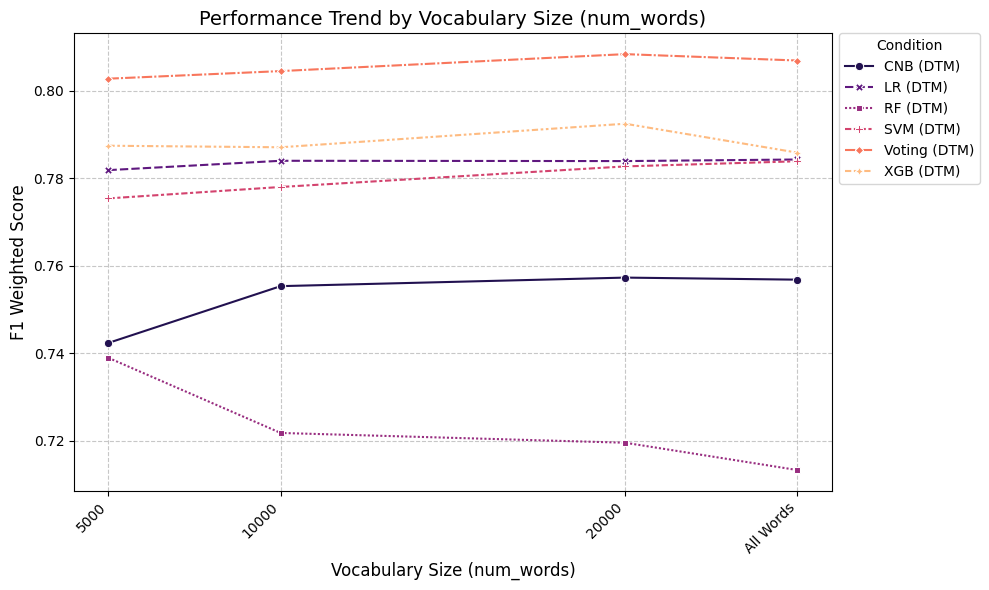

In [122]:
# 1. num_words=None을 그래프의 맨 끝(25000)에 위치시키기 위해 임시 열 생성
results_df['Full_Condition'] = results_df['model'] + ' (' + results_df['bow_type'] + ')'
results_df['num_words_plot'] = results_df['num_words'].fillna(25000)
results_df['num_words_plot'] = results_df['num_words_plot'].astype(int)

# 2. X축 레이블과 틱을 정의합니다.
custom_ticks = sorted(results_df['num_words_plot'].unique())
custom_labels = [str(n) if n < 25000 else 'All Words' for n in custom_ticks]

# 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='num_words_plot',
    y='f1_weighted',
    hue='Full_Condition',
    style='Full_Condition',
    markers=True,
    data=results_df[results_df.bow_type == 'DTM'].sort_values('model'),
    palette='magma',
    errorbar=None # 추세선만 명확히 보기 위해 에러바 제거
)

# X축 틱과 레이블을 None 조건에 맞게 조정
plt.xticks(custom_ticks, custom_labels, rotation=45, ha='right')

# 레이블 및 제목 (영어)
plt.title('Performance Trend by Vocabulary Size (num_words)', fontsize=14)
plt.xlabel('Vocabulary Size (num_words)', fontsize=12)
plt.ylabel('F1 Weighted Score', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(title='Condition', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

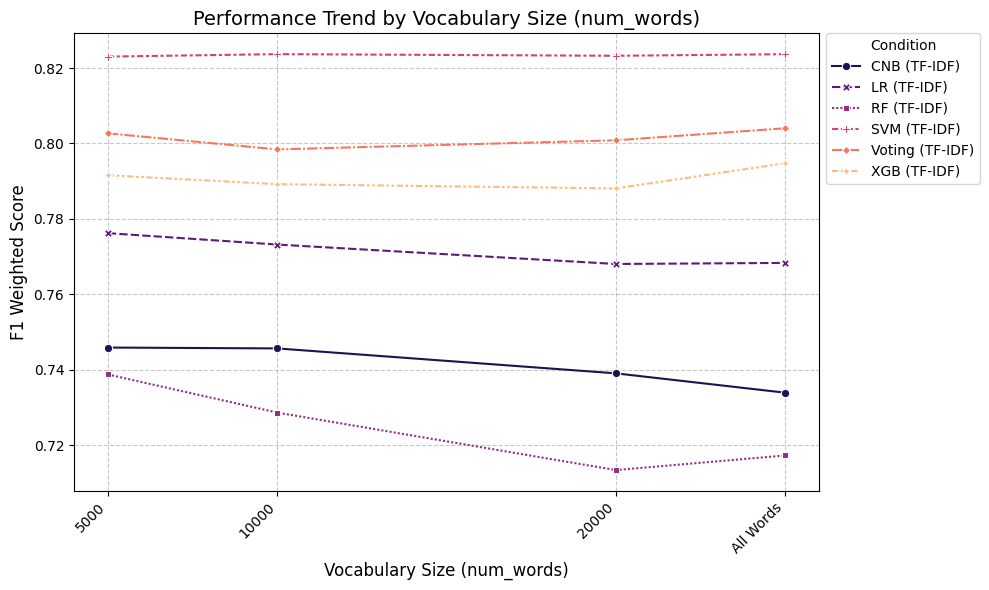

In [123]:
# 1. num_words=None을 그래프의 맨 끝(25000)에 위치시키기 위해 임시 열 생성
results_df['Full_Condition'] = results_df['model'] + ' (' + results_df['bow_type'] + ')'
results_df['num_words_plot'] = results_df['num_words'].fillna(25000)
results_df['num_words_plot'] = results_df['num_words_plot'].astype(int)

# 2. X축 레이블과 틱을 정의합니다.
custom_ticks = sorted(results_df['num_words_plot'].unique())
custom_labels = [str(n) if n < 25000 else 'All Words' for n in custom_ticks]

# 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='num_words_plot',
    y='f1_weighted',
    hue='Full_Condition',
    style='Full_Condition',
    markers=True,
    data=results_df[results_df.bow_type == 'TF-IDF'].sort_values('model'),
    palette='magma',
    errorbar=None # 추세선만 명확히 보기 위해 에러바 제거
)

# X축 틱과 레이블을 None 조건에 맞게 조정
plt.xticks(custom_ticks, custom_labels, rotation=45, ha='right')

# 레이블 및 제목 (영어)
plt.title('Performance Trend by Vocabulary Size (num_words)', fontsize=14)
plt.xlabel('Vocabulary Size (num_words)', fontsize=12)
plt.ylabel('F1 Weighted Score', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(title='Condition', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

`TF-IDF`을 활용한 학습 결과에서는 `RandomForest`, `CNB`, 그리고 `LR`의 경우, `num_words`가 증가함에 따라 `F1-weight`가 감소하였습니다.

## 모델 학습 (class_weight 고려)

In [130]:
# class_weight 계산
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes= np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


In [136]:
# 모델 정의
models_weighted = {
    #'CNB': ComplementNB(), # class_weight 관련 파라미터 없음
    'LR': LogisticRegression(max_iter = 3000, random_state = 42, class_weight=class_weight_dict),
    'SVM': LinearSVC(max_iter=3000, dual=False, random_state=42, class_weight=class_weight_dict),
    'RF': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight_dict),
    'XGB': xgb.XGBClassifier(
        objective='multi:softmax', num_class=46,
        random_state=42, n_jobs=-1
    )
}

soft_voting =  VotingClassifier(
    estimators=[
        ('LR', models_weighted['LR']), ('RF', models_weighted['RF']), ('XGB', models_weighted['XGB'])
        ], voting='soft', n_jobs= -1) # LinearSVC는 'hard'방식만 가능하여 제외 # SVC는 계산량이 너무 많아서 제외

models_weighted['Voting'] = soft_voting

In [138]:
# 모델 학습
n_words_list = [5000, 10000, 20000, None]
bow_types = ['DTM', 'TF-IDF']
results_weighted = []

for n_words in n_words_list:
    for bow_type in bow_types:
        print(f"\n--- 실험 시작: num_words = {n_words}, BoW:{bow_type} ---")

        # 1. 전처리 및 데이터 분할
        X_train, X_test, y_train, y_test = preprocess_bow(num_words=n_words, bow_type=bow_type)

        sample_weights_train = np.array([class_weight_dict[label] for label in y_train])

        # 2. 모델 학습 및 평가
        for model_name, model in models_weighted.items():
            start_time = time.time()
            if model_name == 'XGB':
              model.fit(X_train, y_train, sample_weight=sample_weights_train)
            else:
              model.fit(X_train, y_train)

            end_time = time.time()
            elapsed_time = end_time - start_time

            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_weighted = f1_score(y_test, y_pred, average='weighted')

            # 결과 저장
            results_weighted.append({
                'num_words': n_words,
                'bow_type': bow_type,
                'model': model_name,
                'accuracy': acc,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            })

            print(f"  {model_name} 정확도: {acc:.4f} F1(macro): {f1_macro:.4f} F1(weighted): {f1_weighted:.4f} (학습 시간: {elapsed_time:.2f}초)")


--- 실험 시작: num_words = 5000, BoW:DTM ---
  LR 정확도: 0.7988 F1(macro): 0.6185 F1(weighted): 0.7970 (학습 시간: 24.69초)
  SVM 정확도: 0.7818 F1(macro): 0.5919 F1(weighted): 0.7777 (학습 시간: 96.73초)
  RF 정확도: 0.7787 F1(macro): 0.5791 F1(weighted): 0.7683 (학습 시간: 4.88초)
  XGB 정확도: 0.8059 F1(macro): 0.6831 F1(weighted): 0.8053 (학습 시간: 10.84초)
  Voting 정확도: 0.8175 F1(macro): 0.6705 F1(weighted): 0.8128 (학습 시간: 37.98초)

--- 실험 시작: num_words = 5000, BoW:TF-IDF ---
  LR 정확도: 0.7845 F1(macro): 0.7015 F1(weighted): 0.7908 (학습 시간: 2.30초)
  SVM 정확도: 0.8348 F1(macro): 0.7119 F1(weighted): 0.8365 (학습 시간: 2.09초)
  RF 정확도: 0.7836 F1(macro): 0.6069 F1(weighted): 0.7757 (학습 시간: 5.28초)
  XGB 정확도: 0.8139 F1(macro): 0.6723 F1(weighted): 0.8132 (학습 시간: 151.72초)
  Voting 정확도: 0.8108 F1(macro): 0.6727 F1(weighted): 0.8056 (학습 시간: 227.85초)

--- 실험 시작: num_words = 10000, BoW:DTM ---
  LR 정확도: 0.8028 F1(macro): 0.6215 F1(weighted): 0.8002 (학습 시간: 25.12초)
  SVM 정확도: 0.7912 F1(macro): 0.6234 F1(weighted): 0.7876 (학습 시간: 115

## 결과분석

In [144]:
# 결과 정리
results_weighted_df = pd.DataFrame(results_weighted)
print("\n--- 전체 실험 결과 요약  ---")
results_weighted_df.sort_values(by=['accuracy', 'f1_weighted'], ascending=False)


--- 전체 실험 결과 요약  ---


,num_words,bow_type,model,accuracy,f1_macro,f1_weighted
6,5000.0,TF-IDF,SVM,0.834817,0.711931,0.836532
26,20000.0,TF-IDF,SVM,0.833482,0.709711,0.833639
36,NaN,TF-IDF,SVM,0.832146,0.703756,0.832044
16,10000.0,TF-IDF,SVM,0.831701,0.701460,0.832195
34,NaN,DTM,Voting,0.819234,0.671940,0.814392
14,10000.0,DTM,Voting,0.818344,0.667875,0.813681
4,5000.0,DTM,Voting,0.817453,0.670456,0.812825
24,20000.0,DTM,Voting,0.816118,0.667334,0.811571
38,NaN,TF-IDF,XGB,0.814782,0.672100,0.814686
8,5000.0,TF-IDF,XGB,0.813891,0.672319,0.813160


### Accuracy 기준

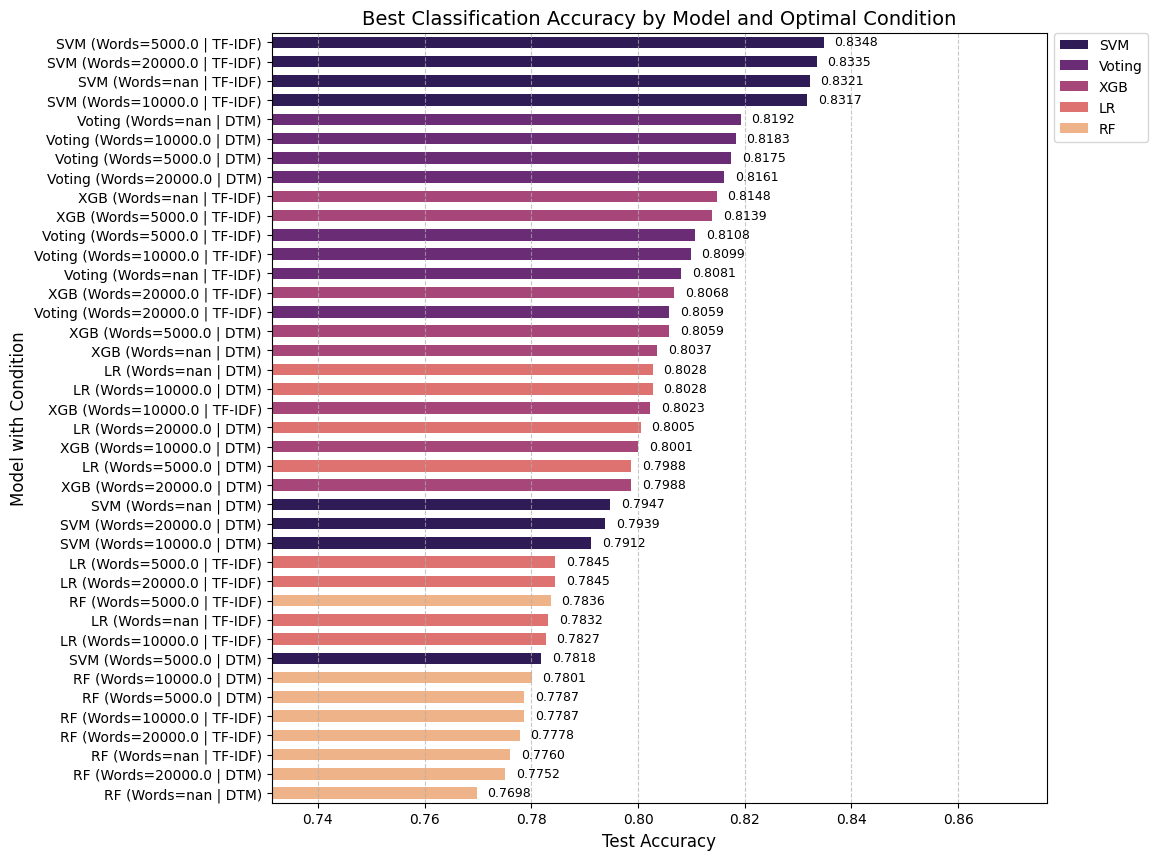

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

best_per_model = pd.DataFrame(results_weighted_df).sort_values('accuracy', ascending=False).reset_index(drop=True)

# 1. Y축 레이블(모델 이름 + 조건) 생성
# 'Model (Words=Num | Type)' 형식으로 결합
best_per_model['Full_Label'] = best_per_model['model'] + ' (Words=' + best_per_model['num_words'].astype(str) + ' | ' + best_per_model['bow_type'].astype(str) + ')'

# 2. 그래프 생성 (Barh)
plt.figure(figsize=(10, 10))
# x축에 accuracy, y축에 결합된 레이블 사용
barhplot = sns.barplot(
    x='accuracy',
    y='Full_Label',
    data=best_per_model,
    hue = 'model',
    width=0.6,
    palette='magma' # 새로운 색상 팔레트
)

plt.title('Best Classification Accuracy by Model and Optimal Condition', fontsize=14)
plt.xlabel('Test Accuracy', fontsize=12)
plt.ylabel('Model with Condition', fontsize=12)
plt.xlim(best_per_model['accuracy'].min() * 0.95, best_per_model['accuracy'].max() * 1.05) # X축 범위 조정

# 막대 끝에 정확도 값 표시
for index, row in best_per_model.iterrows():
    barhplot.text(
        row['accuracy'] + 0.002, # 막대 끝에서 오른쪽으로 약간 이동
        index,
        f"{row['accuracy']:.4f}",
        color='black',
        ha="left",
        va="center",
        size=9
    )

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.) # 범례 위치 조정
plt.show()

- 전체적으로 class weight를 적용한 학습결과가 이전 실험보다 높은 정확도를 보여주었습니다.
- 마찬가지로 `SVM + TF-IDF`가 모든 num_words 조합에서 가장 높은 정확도를 보여주었으며 class_weight를 적용 후 약 0.5%p 정도 정확도가 올랐습니다.
- 그 다음으로는 마찬가지로 Voting 분류기가 모든 조합에서 준수한 정확도를 보여주었습니다만 `XGBoost + TF-DF`의 정확도가 약 1.5%p 정도 올랐습니다.
- `RandomForest`는 모든 num_words, bow_type 조합에서 가장 낮은 정확도를 보여주었습니다.


### F1-Score 기준

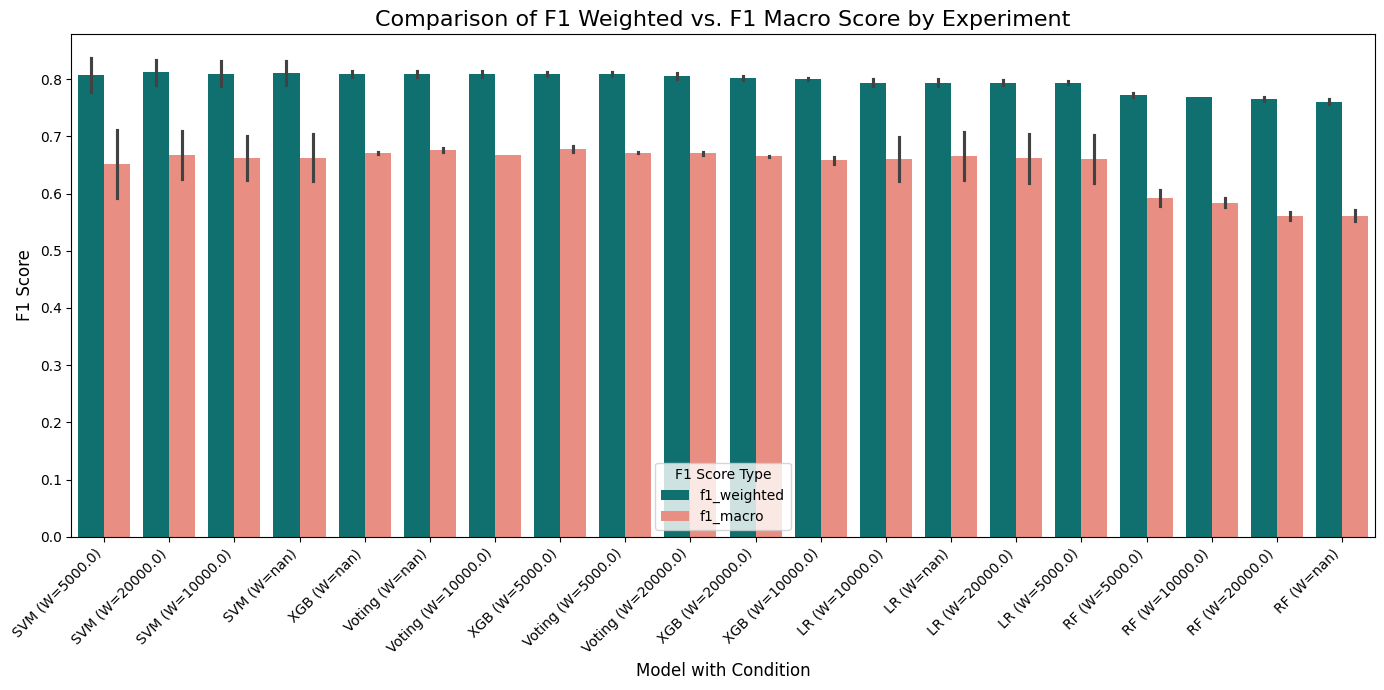

In [146]:
# `F1_macro`와 `F1_weighted`를 비교한 그래프
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. 시각화를 위해 F1 Score 열을 하나로 합쳐서 재구조화 (Wide to Long)
f1_melted = results_weighted_df.melt(
    id_vars=['model', 'num_words', 'bow_type'],
    value_vars=['f1_macro', 'f1_weighted'],
    var_name='F1_Type',
    value_name='F1_Score'
).sort_values('F1_Score', ascending=False)

# 2. X축 레이블을 결합하여 생성
f1_melted['Condition'] = f1_melted['model'] + ' (W=' + f1_melted['num_words'].astype(str) + ')'

plt.figure(figsize=(14, 7))

# Bar Plot 생성
barplot = sns.barplot(
    x='Condition',
    y='F1_Score',
    hue='F1_Type', # f1_macro와 f1_weighted를 그룹으로 구분
    data=f1_melted,
    palette={'f1_weighted': 'teal', 'f1_macro': 'salmon'} # 색상 지정
)

plt.title('Comparison of F1 Weighted vs. F1 Macro Score by Experiment', fontsize=16)
plt.xlabel('Model with Condition', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45, ha='right') # X축 레이블 회전하여 가독성 확보

# 막대 위에 값 표시 (선택 사항: 복잡해 보일 수 있으므로 주의)
# for container in barplot.containers:
#     barplot.bar_label(container, fmt='%.3f', size=8)

plt.legend(title='F1 Score Type')
plt.tight_layout()
plt.show()

### num_words 기준

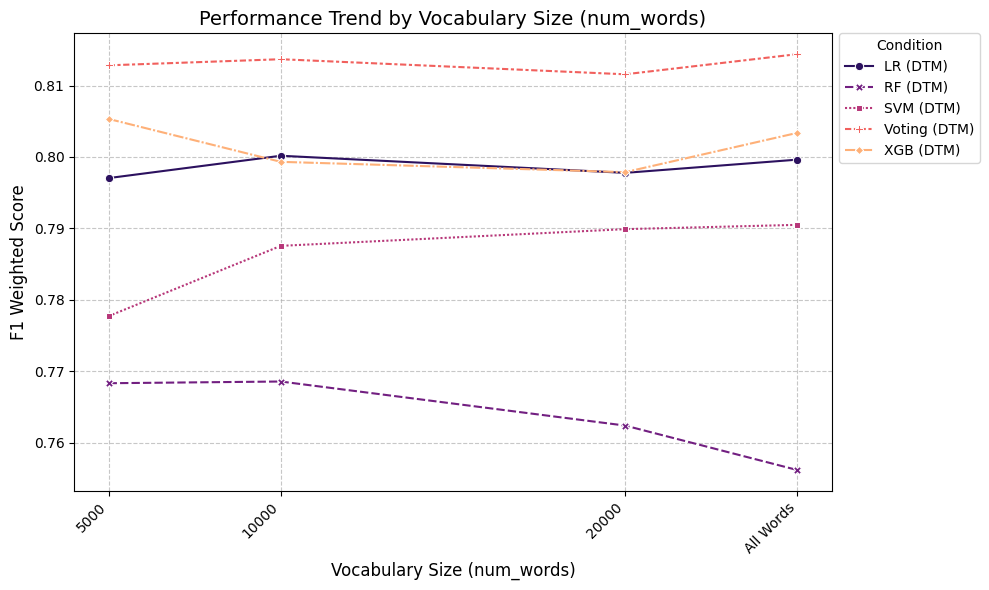

In [148]:
# 1. num_words=None을 그래프의 맨 끝(25000)에 위치시키기 위해 임시 열 생성
results_weighted_df['Full_Condition'] = results_weighted_df['model'] + ' (' + results_weighted_df['bow_type'] + ')'
results_weighted_df['num_words_plot'] = results_weighted_df['num_words'].fillna(25000)
results_weighted_df['num_words_plot'] = results_weighted_df['num_words_plot'].astype(int)

# 2. X축 레이블과 틱을 정의합니다.
custom_ticks = sorted(results_weighted_df['num_words_plot'].unique())
custom_labels = [str(n) if n < 25000 else 'All Words' for n in custom_ticks]

# 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='num_words_plot',
    y='f1_weighted',
    hue='Full_Condition',
    style='Full_Condition',
    markers=True,
    data=results_weighted_df[results_weighted_df.bow_type == 'DTM'].sort_values('model'),
    palette='magma',
    errorbar=None # 추세선만 명확히 보기 위해 에러바 제거
)

# X축 틱과 레이블을 None 조건에 맞게 조정
plt.xticks(custom_ticks, custom_labels, rotation=45, ha='right')

# 레이블 및 제목 (영어)
plt.title('Performance Trend by Vocabulary Size (num_words)', fontsize=14)
plt.xlabel('Vocabulary Size (num_words)', fontsize=12)
plt.ylabel('F1 Weighted Score', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(title='Condition', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

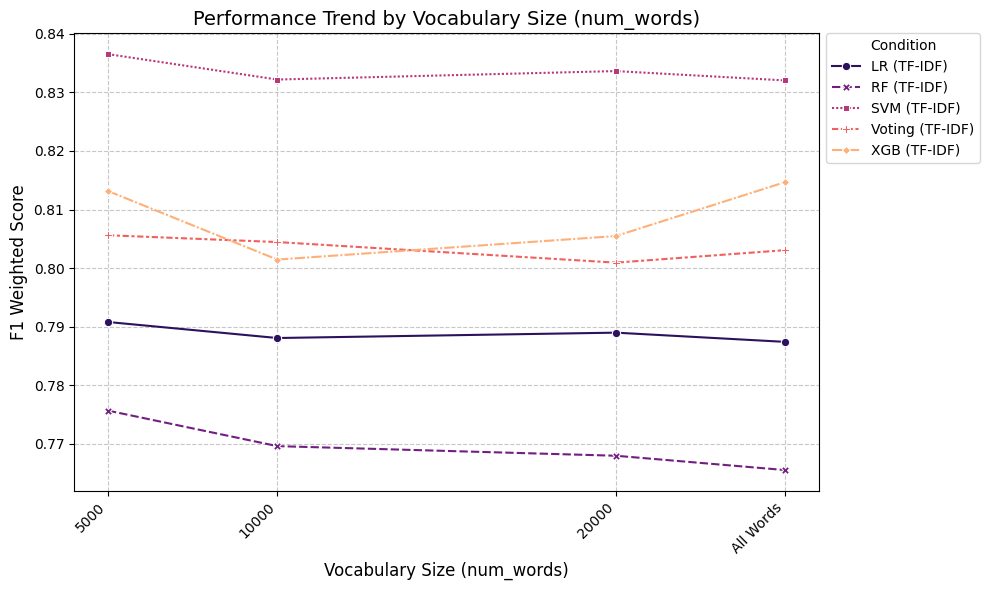

In [149]:
# 1. num_words=None을 그래프의 맨 끝(25000)에 위치시키기 위해 임시 열 생성
results_weighted_df['Full_Condition'] = results_weighted_df['model'] + ' (' + results_weighted_df['bow_type'] + ')'
results_weighted_df['num_words_plot'] = results_weighted_df['num_words'].fillna(25000)
results_weighted_df['num_words_plot'] = results_weighted_df['num_words_plot'].astype(int)

# 2. X축 레이블과 틱을 정의합니다.
custom_ticks = sorted(results_weighted_df['num_words_plot'].unique())
custom_labels = [str(n) if n < 25000 else 'All Words' for n in custom_ticks]

# 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='num_words_plot',
    y='f1_weighted',
    hue='Full_Condition',
    style='Full_Condition',
    markers=True,
    data=results_weighted_df[results_weighted_df.bow_type == 'TF-IDF'].sort_values('model'),
    palette='magma',
    errorbar=None # 추세선만 명확히 보기 위해 에러바 제거
)

# X축 틱과 레이블을 None 조건에 맞게 조정
plt.xticks(custom_ticks, custom_labels, rotation=45, ha='right')

# 레이블 및 제목 (영어)
plt.title('Performance Trend by Vocabulary Size (num_words)', fontsize=14)
plt.xlabel('Vocabulary Size (num_words)', fontsize=12)
plt.ylabel('F1 Weighted Score', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(title='Condition', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

# 추가. Keras Embedding + DL Model

분석 개요
___
1. reuters 데이터의 문서 길이 분석
    - num_words에 따른 문서 길이 분포 시각화
    - num_words별 95% MAX_SEQUENCE_LENGTH_95 찾기
    
2. num_words에 따른 reuters 데이터 불러오기 및 전처리 함수 생성
    - reuters 데이터 및 word_index 로드
    - 토큰화 (num_words 필터링 적용) : 정수형 시퀀스로 변환
    - 패딩을 통한 텍스트 길이 전처리
    - OneHot Encoding 적용
2. 모델 학습
    - 모델: RNN (LSTM/GRU) 또는 1D CNN 모델
    - 임베딩: Keras Embedding Layer 활용

3. 결과 정리 및 비교


## reuters 데이터 내 문서 길이 분석
___

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

def plot_sequence_length_distribution_95th(num_words=5000):
    """
    Reuters 데이터셋의 문서 길이 분포를 시각화하고 95% 분위수를 계산하는 함수.
    """
    PERCENTILE = 95

    print(f"--- Reuters Document Length Distribution Analysis (num_words={num_words}) ---")

    # 1. 데이터 로드 (num_words 필터링 적용)
    (X_train_raw, _), (_, _) = reuters.load_data(num_words=num_words)

    # 2. 문서 길이 계산
    train_lengths = [len(s) for s in X_train_raw]

    # 3. 95% 분위수 계산 (95% 적용)
    max_len_95th = int(np.percentile(train_lengths, PERCENTILE))
    print(f"Total documents: {len(train_lengths)}")
    print(f"{PERCENTILE}th Percentile Length (Recommended MAX_SEQUENCE_LENGTH): {max_len_95th}")
    print(f"Average document length: {np.mean(train_lengths):.2f}")

    # 4. 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(train_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    # 95% 분위수 지점 표시
    plt.axvline(max_len_95th, color='red', linestyle='dashed', linewidth=2,
                label=f'{PERCENTILE}th Percentile: {max_len_95th}')

    plt.title(f'Reuters Training Data Document Length Distribution (Top {num_words} Words)')
    plt.xlabel('Document Length (Number of Words)')
    plt.ylabel('Frequency')

    # 범례 표시
    plt.legend()

    plt.grid(axis='y', alpha=0.5)
    plt.show()

def calculate_95th_percentile_lengths(num_words_list):
    """
    주어진 num_words 리스트에 대해 reuters 데이터셋의 95분위수 문서 길이를 계산합니다.
    """
    length_dict = {}
    PERCENTILE = 95

    for num_words in num_words_list:
        print(f"Loading data for num_words={num_words}...")
        (X_train_raw, _), (_, _) = reuters.load_data(num_words=num_words, test_split=0.2)

        # 문서 길이 계산
        train_lengths = [len(s) for s in X_train_raw]

        # 95% 분위수 계산
        max_len_95th = int(np.percentile(train_lengths, PERCENTILE))

        # 결과 딕셔너리에 저장
        length_dict[num_words] = max_len_95th

        print(f"  -> 95th Percentile Length: {max_len_95th}\n")

    return length_dict

--- Reuters Document Length Distribution Analysis (num_words=5000) ---
Total documents: 8982
95th Percentile Length (Recommended MAX_SEQUENCE_LENGTH): 459
Average document length: 145.54


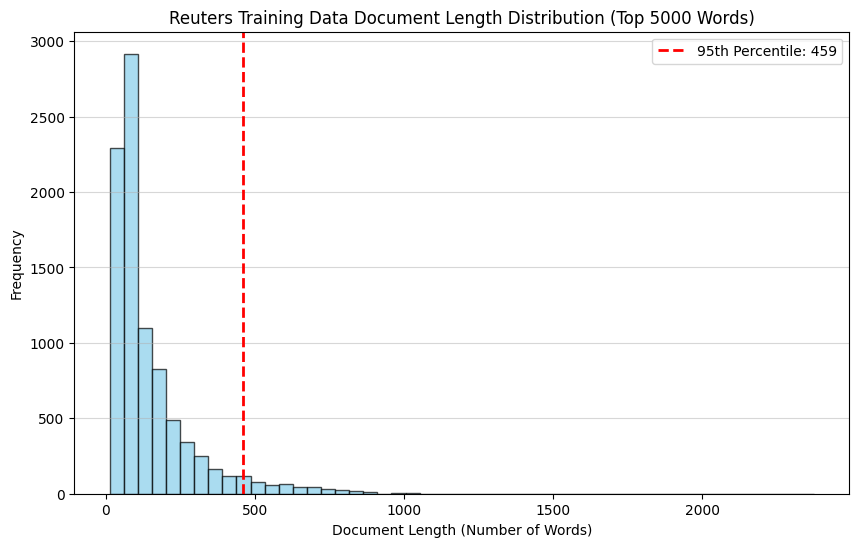

In [3]:
# reuters 문서 길이 시각화
plot_sequence_length_distribution_95th(num_words=5000)

In [6]:
# padding을 위한 num_words별 95% 길이 찾기
num_words_list = [5000, 10000, 20000, None]
max_len_dict = calculate_95th_percentile_lengths(num_words_list)

print("="*50)
print("MAX_SEQUENCE_LENGTH (95th Percentile) by num_words:")
print(max_len_dict)
print("="*50)

Loading data for num_words=5000...
  -> 95th Percentile Length: 459

Loading data for num_words=10000...
  -> 95th Percentile Length: 459

Loading data for num_words=20000...
  -> 95th Percentile Length: 459

Loading data for num_words=None...
  -> 95th Percentile Length: 459

MAX_SEQUENCE_LENGTH (95th Percentile) by num_words:
{5000: 459, 10000: 459, 20000: 459, None: 459}


위 분석결과에 따라 모든 num_words에 대해 MAX_SEQUENCE_LENGTH는 459로 적용하였습니다

## 데이터 전처리 함수

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocess_reuters_data(num_words, max_sequence_length = 459):
    # 1. 데이터 로드 (num_words 필터링 적용)
    (X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = reuters.load_data(num_words=num_words, test_split=0.2)

    # 2. 패딩 (Padding) 적용
    X_train = pad_sequences(X_train_raw, maxlen=max_sequence_length)
    X_test = pad_sequences(X_test_raw, maxlen=max_sequence_length)

    # 3. 레이블 One-Hot Encoding 적용
    NUM_CLASSES = max(y_train_raw) + 1
    y_train = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
    y_test = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

    return X_train, X_test, y_train, y_test, NUM_CLASSES

In [8]:
# 전처리 함수 실행 예시 (95% 적용)
X_train, X_test, y_train, y_test, NUM_CLASSES = preprocess_reuters_data(num_words = 5000)

print(f"**전처리 완료 (num_words = 5000 적용 시)**")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

**전처리 완료 (num_words = 5000 적용 시)**
X_train shape: (8982, 459)
y_train shape: (8982, 46)


## 모델 학습

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def build_lstm_model(vocab_size, max_len=459, embedding_dim=100, lstm_units=128, dropout_rate= 0.3):
    model = Sequential([
        # Embedding Layer: 입력층. (vocab_size, max_len) -> (max_len, embedding_dim)
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, name='embedding_layer'),

        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, name='lstm_layer'),

        Dense(46, activation='softmax', name='output_layer')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# 모델 생성
NUM_WORDS = 5000
lstm_model = build_lstm_model(vocab_size = NUM_WORDS)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 콜백 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model_5000.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

# 모델 학습
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3499 - loss: 2.5940
Epoch 1: val_loss improved from None to 1.82916, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 85s 293ms/step - accuracy: 0.4202 - loss: 2.2197 - val_accuracy: 0.5267 - val_loss: 1.8292
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5170 - loss: 1.8147
Epoch 2: val_loss improved from 1.82916 to 1.71432, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 282ms/step - accuracy: 0.5399 - loss: 1.7593 - val_accuracy: 0.5610 - val_loss: 1.7143
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5684 - loss: 1.6738
Epoch 3: val_loss improved from 1.71432 to 1.63654, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.5779 - loss: 1.6588 - val_accuracy: 0.6086 - val_loss: 1.6365
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5991 - loss: 1.5978
Epoch 4: val_loss improved from 1.63654 to 1.59364, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 296ms/step - accuracy: 0.6137 - loss: 1.5471 - val_accuracy: 0.6033 - val_loss: 1.5936
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6219 - loss: 1.4960
Epoch 5: val_loss improved from 1.59364 to 1.45994, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.6381 - loss: 1.4440 - val_accuracy: 0.6438 - val_loss: 1.4599
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6601 - loss: 1.3446
Epoch 6: val_loss improved from 1.45994 to 1.40984, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 297ms/step - accuracy: 0.6642 - loss: 1.3207 - val_accuracy: 0.6434 - val_loss: 1.4098
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6917 - loss: 1.2199
Epoch 7: val_loss improved from 1.40984 to 1.32784, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 298ms/step - accuracy: 0.6869 - loss: 1.2301 - val_accuracy: 0.6652 - val_loss: 1.3278
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7092 - loss: 1.1362
Epoch 8: val_loss improved from 1.32784 to 1.24896, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.7091 - loss: 1.1243 - val_accuracy: 0.6874 - val_loss: 1.2490
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7332 - loss: 1.0186
Epoch 9: val_loss improved from 1.24896 to 1.21239, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 289ms/step - accuracy: 0.7368 - loss: 1.0232 - val_accuracy: 0.6919 - val_loss: 1.2124
Epoch 10/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7500 - loss: 0.9481
Epoch 10: val_loss improved from 1.21239 to 1.16954, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 290ms/step - accuracy: 0.7473 - loss: 0.9665 - val_accuracy: 0.7186 - val_loss: 1.1695
Epoch 11/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7733 - loss: 0.8822
Epoch 11: val_loss improved from 1.16954 to 1.15897, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 289ms/step - accuracy: 0.7781 - loss: 0.8695 - val_accuracy: 0.7128 - val_loss: 1.1590
Epoch 12/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7968 - loss: 0.7971
Epoch 12: val_loss improved from 1.15897 to 1.12404, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0.7990 - loss: 0.7917 - val_accuracy: 0.7329 - val_loss: 1.1240
Epoch 13/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8244 - loss: 0.6940
Epoch 13: val_loss improved from 1.12404 to 1.10455, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 293ms/step - accuracy: 0.8198 - loss: 0.7092 - val_accuracy: 0.7386 - val_loss: 1.1045
Epoch 14/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8366 - loss: 0.6251
Epoch 14: val_loss did not improve from 1.10455
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.8356 - loss: 0.6398 - val_accuracy: 0.7422 - val_loss: 1.1153
Epoch 15/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8580 - loss: 0.5911
Epoch 15: val_loss improved from 1.10455 to 1.10206, saving model to best_lstm_model_5000.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 293ms/step - accuracy: 0.8533 - loss: 0.5828 - val_accuracy: 0.7480 - val_loss: 1.1021
Epoch 16/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8734 - loss: 0.5116
Epoch 16: val_loss did not improve from 1.10206
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.8742 - loss: 0.5114 - val_accuracy: 0.7556 - val_loss: 1.1182
Epoch 17/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8898 - loss: 0.4330
Epoch 17: val_loss did not improve from 1.10206
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.8808 - loss: 0.4768 - val_accuracy: 0.7627 - val_loss: 1.1027
Epoch 18/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8966 - loss: 0.4193
Epoch 18: val_loss did not improve from 1.10206
281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.8943 - loss: 0.4255 - val_accuracy: 0.7614 - val_loss: 1.1463
Epoch 19/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9033 - loss: 0.3729
Epoch 19: val_loss d

## 모델 평가

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    학습 이력(loss, accuracy)을 시각화하는 함수.
    """
    history_dict = history.history

    # Early Stopping이 적용되었을 경우, 최종 에포크를 결정
    epochs = range(1, len(history_dict['loss']) + 1)

    # ------------------ 손실 (Loss) 그래프 ------------------
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'b-', label='Training loss')
    plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # ------------------ 정확도 (Accuracy) 그래프 ------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training accuracy')
    plt.plot(epochs, history_dict['val_accuracy'], 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [20]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBoW (num_words={NUM_WORDS}) Test Accuracy: {accuracy*100:.2f}%")


BoW (num_words=5000) Test Accuracy: 74.80%


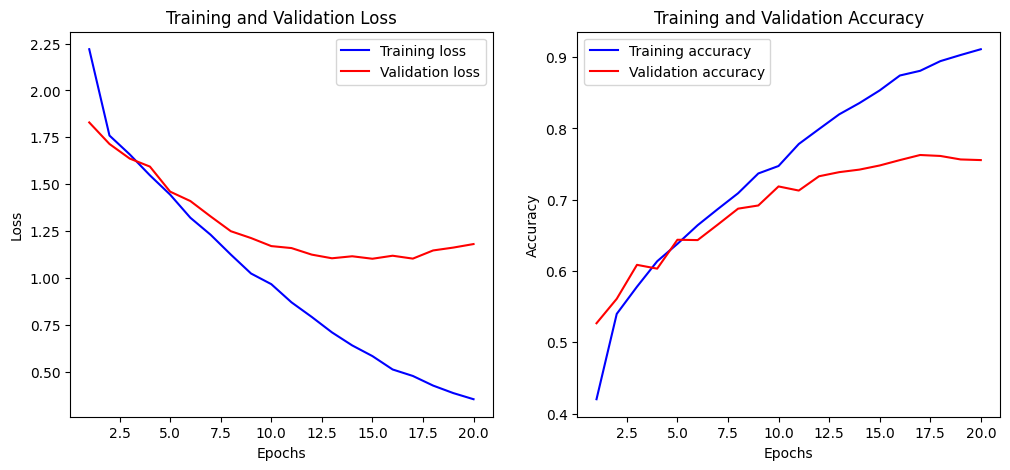

In [22]:
plot_history(history_lstm)

튜닝을 적극적으로 하지 않아 과적합 상태이지만 validation accuracy가 낮지 않은 결과를 얻었습니다. training accuracy를 고려했을 때, 더 높은 validation accuracy를 얻을 수 있을 거라고 생각합니다.

# 총평
- DL 모델 적용을 위한 전처리 방법에 대해 추가 학습하느라 실험 설계가 늦어져 결과 도출이 꽤 지연되었습니다. 텍스트 데이터 특성상 volume이 큰편이기 때문에 DL 모델을 주로 활용하게 될거라고 생각하기 때문에 이 부분은 필히 숙지해야할 것 같습니다.
- num_words에 따른 BoW를 활용한 ML 모델 학습을 통해 다중 텍스트 분류에 SVM이 적합한 성능을 보여준다는 점을 확인하여 반가웠습니다.
- 여유가 된다면 각 모델에 대한 튜닝도 실시하여 DL모델과 비교해보고 싶습니다.